In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from plotnine import *

plt.style.use("seaborn")
%matplotlib inline

In [6]:
## Dataset loading
df = pd.read_csv("../data/Anonymized_Buckeye_issue_log_dataset.csv", encoding="ISO-8859-1", index_col=0)
dims = df.shape
ti = df["SentOn"].values[0].replace("+00:00", "")
tf = df["SentOn"].values[-1].replace("+00:00", "")
dt = datetime.strptime(tf, '%Y-%m-%d %H:%M:%S') - datetime.strptime(ti, '%Y-%m-%d %H:%M:%S')
df = df.dropna()

# Timelines definition
senton_time = [datetime.strptime(d.replace("+00:00", ""), 
                          '%Y-%m-%d %H:%M:%S') for d in df["SentOn"].values]
senton_timeline = np.cumsum(np.diff(senton_time))
senton_timeline = [0] + [el.seconds for el in senton_timeline]

received_time = [datetime.strptime(d.replace("+00:00", ""), 
                          '%Y-%m-%d %H:%M:%S') for d in df["ReceivedTime"].values]
received_timeline = np.cumsum(np.diff(received_time))
received_timeline = [0] + [el.seconds for el in received_timeline]
delay = [(r-s) for r, s in zip(received_timeline, senton_timeline)]
df_time = pd.DataFrame()
df_time['senton'] = senton_timeline
df_time['received'] = received_timeline
df_time['delay'] = delay

# Angriness binned
labels = ('Not angry', 'Moderately angry', 'Angry')
bins = [0, 0.3, 0.8, 1]
df["AngrinessBinned"] = pd.cut(df["Angriness"], bins, labels=labels)

In [7]:
df.head()

,Region,SentOn,ReceivedTime,LetterCount,Angriness,AngrinessBinned
0,East,2017-11-01 13:54:03+00:00,2017-11-01 14:02:18+00:00,83,0.183908,Not angry
1,East,2017-11-01 14:08:08+00:00,2017-11-01 15:27:13+00:00,200,0.061204,Not angry
2,Americas,2017-11-01 14:08:17+00:00,2017-11-01 14:17:11+00:00,46,0.113445,Not angry
3,Americas,2017-11-01 14:08:55+00:00,2017-11-01 15:07:49+00:00,50,0.094595,Not angry
4,Americas,2017-11-01 14:09:42+00:00,2017-11-01 14:18:24+00:00,65,0.054688,Not angry


# Q1

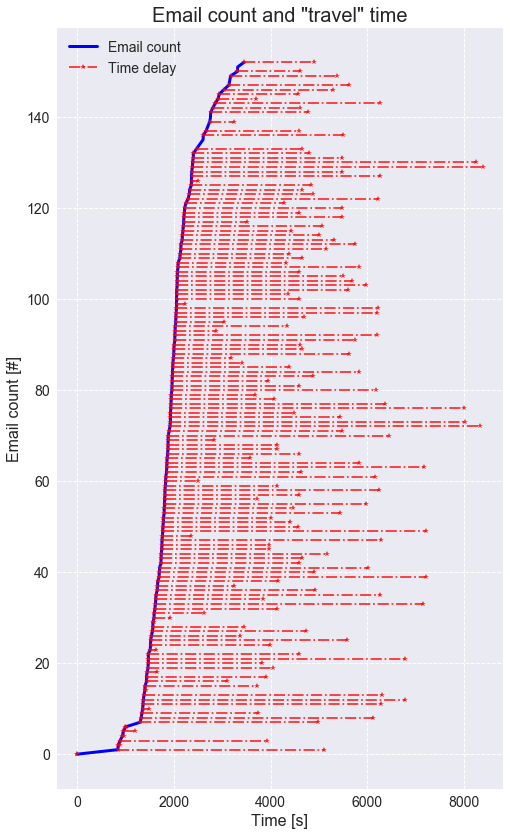

In [8]:
fig = plt.figure(figsize=(8, 14))
plt.plot(senton_timeline, df.index, 'b', lw=3)
for idx in df.index:
    try:
        plt.plot((senton_timeline[idx], senton_timeline[idx]+delay[idx]),
                 (df.index[idx], df.index[idx]), 
                 'r-.*', alpha=0.8, ms=6)
    except IndexError:
        pass
plt.grid(True, linestyle='--')
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('Email count [#]', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.legend(('Email count', 'Time delay'), loc=2, fontsize=14)
plt.title('Email count and "travel" time', size=20)
plt.savefig('../images/eda_q1.png')

/home/peppe/.virtualenvs/py35/lib/python3.5/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/peppe/.virtualenvs/py35/lib/python3.5/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: ../images/eda_q1_2.png
  warn('Filename: {}'.format(filename))


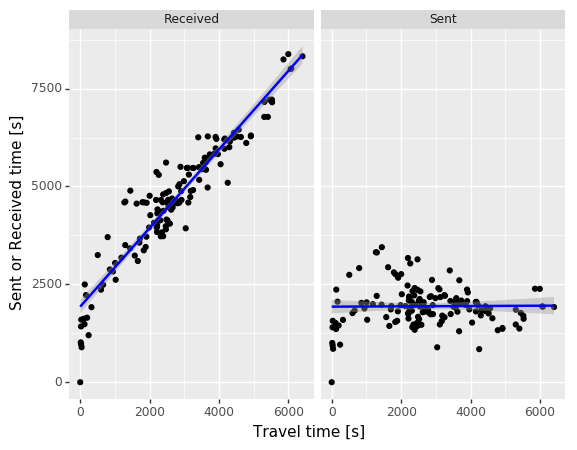

In [52]:
df2 = pd.DataFrame()
df2['Travel time [s]'] = np.hstack((df_time['delay'], df_time['delay']))
df2['Sent or Received time [s]'] = np.hstack((df_time['senton'], df_time['received']))
df2['SentReceived'] = np.hstack(((150*['Sent']), (150*['Received'])))

p1 = ggplot(df2, aes(x='Travel time [s]', y='Sent or Received time [s]',)) \
    + geom_point() \
    + facet_grid('.~SentReceived') \
    + stat_smooth(method='lm',  color='blue')

ggplot.draw(p1)
ggplot.save(p1, filename='eda_q1_2.png', path='../images')

In [11]:
multiplot

NameError: name 'multiplot' is not defined

# Q2 - 

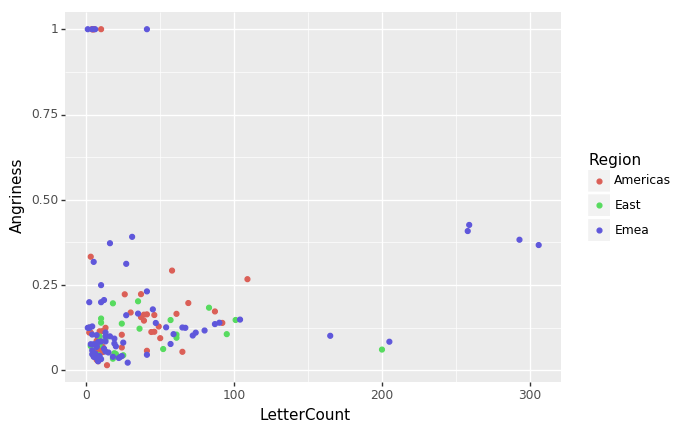

<ggplot: (-9223372036841990652)>

In [6]:
ggplot(df, aes(x="LetterCount", y="Angriness", color='Region',)) \
    + geom_point()

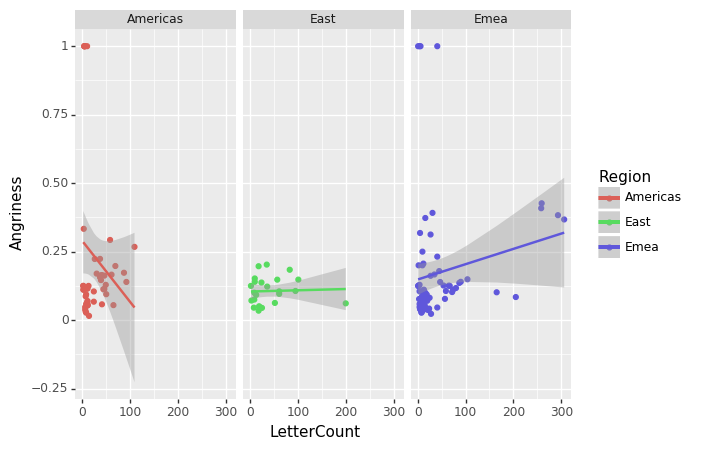

<ggplot: (12822234)>

In [7]:
ggplot(df, aes(x="LetterCount", y="Angriness", color='Region',)) \
    + geom_point() \
    + facet_grid('.~Region') \
    + stat_smooth(method='glm')

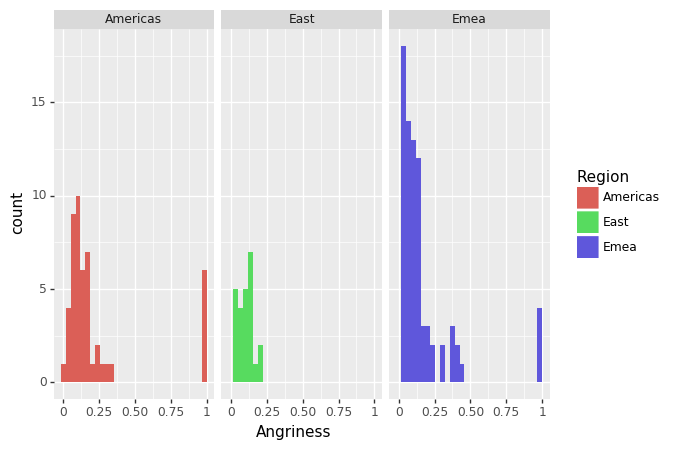

<ggplot: (-9223372036841927869)>

In [8]:
ggplot(df, aes(x="Angriness", fill='Region')) \
    + geom_histogram(bins=30) \
    + facet_grid('.~Region')

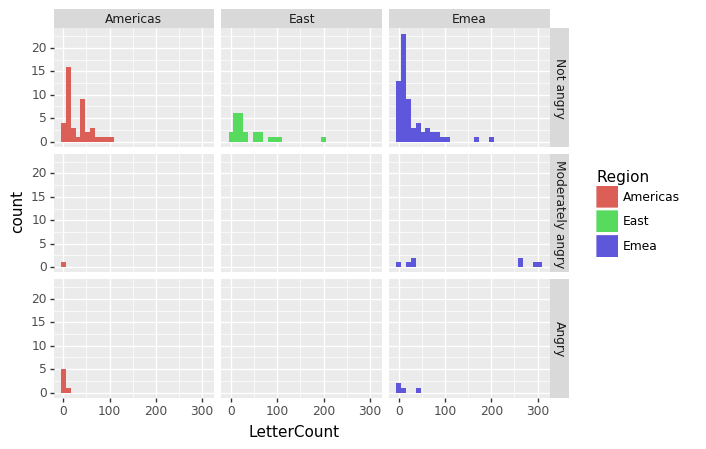

<ggplot: (-9223372036839986891)>

In [10]:
ggplot(df, aes(x="LetterCount", fill='Region')) \
    + geom_histogram(bins=30, inherit_aes=True) \
    + facet_grid("AngrinessBinned~Region")

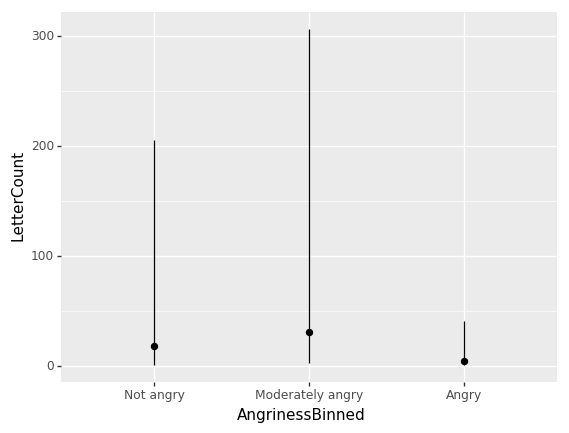

<ggplot: (-9223372036839797188)>

In [11]:
ggplot(aes(x='AngrinessBinned', y='LetterCount'), data=df) \
    + stat_summary(fun_y = np.median, fun_ymin=np.min, fun_ymax=np.max)

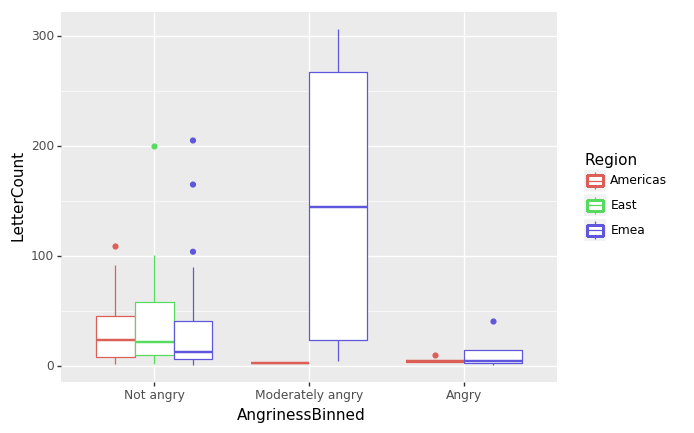

<ggplot: (13482893)>

In [12]:
ggplot(df, aes(x='AngrinessBinned', y='LetterCount', color='Region')) \
    + geom_boxplot()

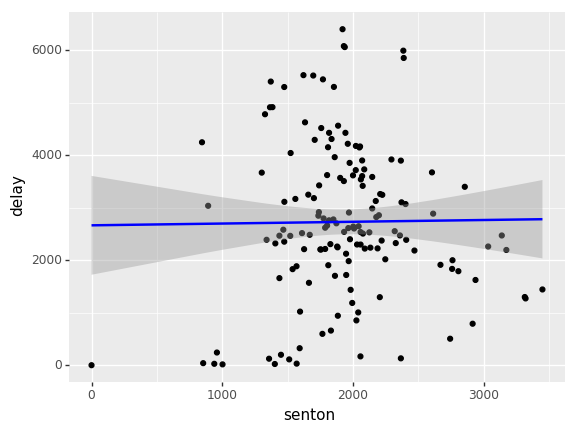

<ggplot: (15184406)>

---